# Projekt z przedmiotu Zaawansowane metody uczenia maszynowego
Temat projektu: Przewidywanie ceny złota na podstawie dotychczasowych notowań

Autor: Edyta Margol

# Wstęp
Projekt dotyczy ceny złota na przestrzeni lat. Zbiór danych został pobrany ze strony https://www.kaggle.com/datasets/arashnic/learn-time-series-forecasting-from-gold-price i zawiera dwie zmienne:
* Date - data, kiedy zanotowano cenę złota,
* Value - zanotowana cena złota w danym dniu.

Dane były zbierane od roku 1970 do 2020, w odstępach mniej więcej trzymiesięcznych (mniej wiecej, ponieważ notowania ceny nie były zapisywane równo co 3 miesiące). Projekt będzie polegać na przewidzeniu ceny na 30 dni do przodu.

In [1]:
options(warn = -1)
suppressPackageStartupMessages(library(dplyr))

In [2]:
suppressMessages({install.packages("tfdatasets")
install.packages("keras")
install.packages("tensorflow")})

In [3]:
library(tfdatasets)
library(keras)
library(tensorflow)

In [4]:
data <- read.csv("/kaggle/input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv")
head(data)

,Date,Value
,<chr>,<dbl>
1,1970-01-01,35.2
2,1970-04-01,35.1
3,1970-07-01,35.4
4,1970-10-01,36.2
5,1971-01-01,37.4
6,1971-04-01,38.9


In [5]:
#sprawdzanie brakow danych
sum(is.na(data))

#sprawdzenie duplikatow danych
sum(duplicated(data))

[1] 0

[1] 0

W celu sprawdzenia czy dane wymagają czyszczenia wykonałam:
* sprawdzenie czy dane zawierają braki - nie zawierają,
* sprawdzenie czy dane zawierają duplikaty - nie zawierają.

# Wstępna analiza
W celu zrozumienia struktury i jakości danych oraz identyfikacji potencjalnych problemów, które mogłyby wpłynąć na dalsze etapy analizy, w pierwszej kolejności przekonwertowałam datę do typu Date.

In [6]:
#przeksztalcenie daty do typu DateTime
data$Date <- as.Date(data$Date)

Sprawdziłam podstawowe statystyki zbioru.

In [7]:
summary(data)

      Date                Value       
 Min.   :1970-01-01   Min.   :  35.1  
 1st Qu.:1989-03-11   1st Qu.: 349.2  
 Median :1999-07-13   Median : 409.4  
 Mean   :1999-07-07   Mean   : 653.6  
 3rd Qu.:2009-11-11   3rd Qu.:1061.6  
 Max.   :2020-03-13   Max.   :1895.0  

Narysowałam wykres zależności ceny od daty:

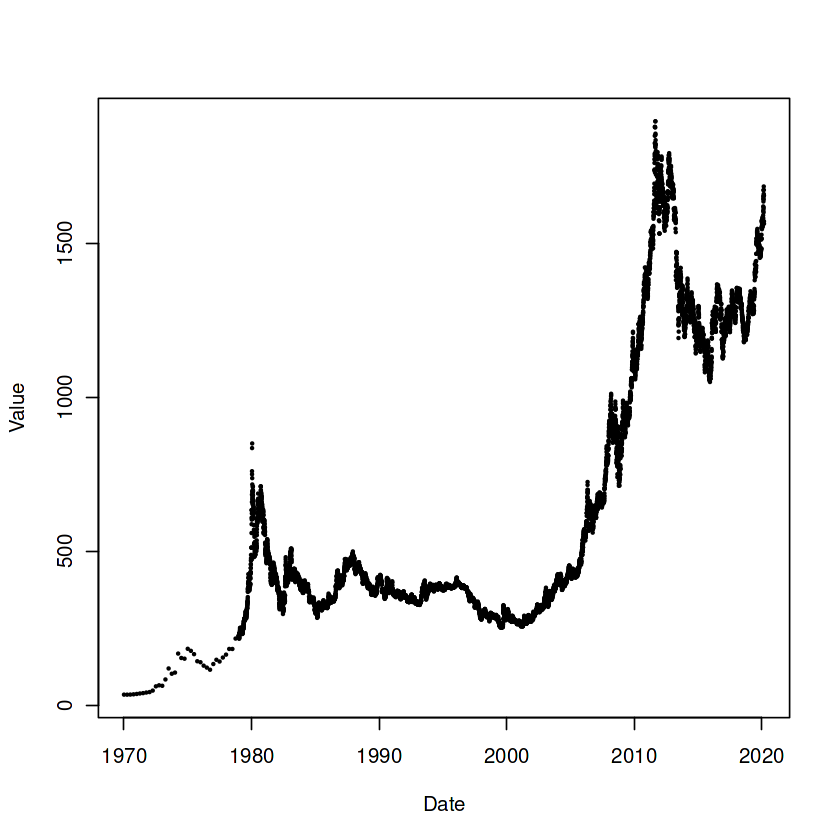

In [8]:
plot(Value ~ Date, data = data, pch = 20, cex = .3)

Można zauważyć, że duża rozbieżność ceny w zbiorze danych wynika ze wzrostu ceny oraz wahań cen złota na przestrzeni lat

Następnie naprawimy problem nierównych odstępów czasowych pomiędzy obserwacjami. Czasami cenę notowano 1. dnia miesiąca, czasami 2. itd, a czasami nawet 14. itd. Dokonamy więc resamplingu, czyli przekształcimy zbiór danych do postaci, gdzie cena będzie zapisywana codziennie. Wartości cen dla nowych dat będą uzupełniane najnowszą znaną ceną.

Sprawdzimy jeszcze rozkład zmiennej Value.

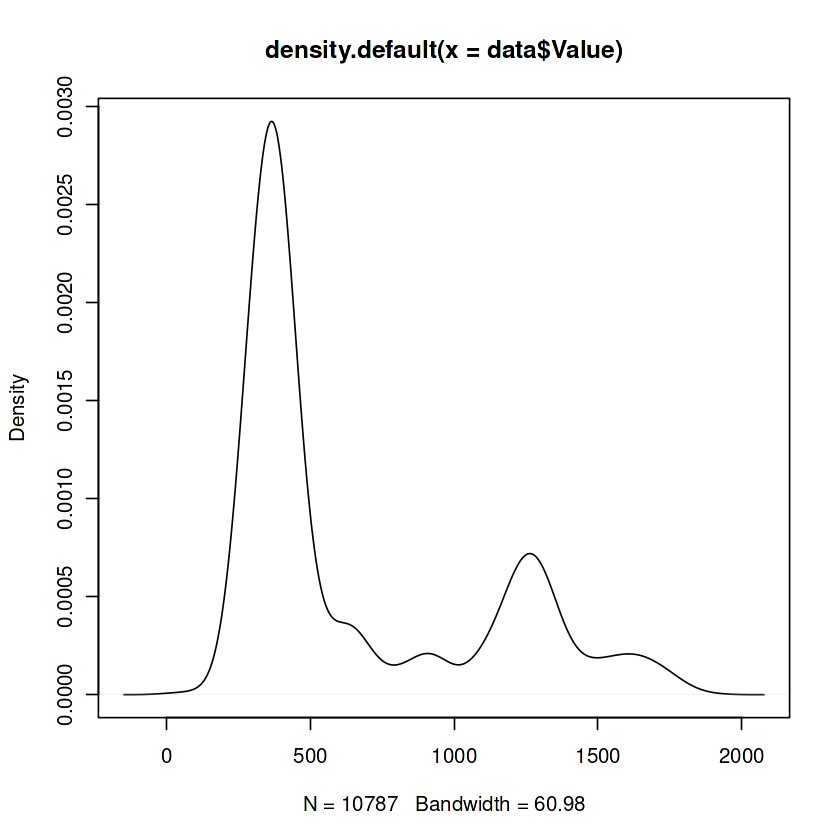

In [9]:
library(dplyr)
library(tidyr)
  df <- data %>%
  group_by(Date) %>%
  summarise(Value = mean(Value)) %>%
  complete(Date = seq.Date(min(Date), max(Date), by = "day")) %>%
  fill(Value)

plot(density(data$Value))

Możemy zauważyć, że rozkład zmiennej Value nie jest symetryczny, a zatem raczej nie jest też normalny.

# Modelowanie
## Przetworzenie danych do modelowania
Dokonamy podziału zbioru danych w proporcjach: 50% obserwacji do zbioru treningowego, kolejne 25% do walidacyjnego i 25% do testowego.

In [10]:
#ogolny podzial danych

# Obliczanie liczby próbek dla każdego zbioru
num_samples <- nrow(df)
num_train_samples <- round(num_samples * 0.5)
num_val_samples <- round(num_samples * 0.25)
num_test_samples <- num_samples - num_train_samples - num_val_samples

# Indeksy dla zbioru treningowego
train_indices <- seq_len(num_train_samples)

# Indeksy dla zbioru walidacyjnego
val_indices <- seq(from = num_train_samples + 1,
                   length.out = num_val_samples)

# Indeksy dla zbioru testowego
test_indices <- seq(from = num_train_samples + num_val_samples + 1,
                    length.out = num_test_samples)

# Podział danych na zbiory
train <- df[train_indices, ]
val <- df[val_indices, ]
test <- df[test_indices, ]

Dokonamy również normalizacji zmiennej Value.

In [11]:
# Obliczanie średniej i odchylenia standardowego dla kolumny 'Value' w zbiorze treningowym
normalization_values <- list(
  mean = mean(train$Value),
  sd = sd(train$Value)
)

#definiowanie funkcji normalizujacej
normalize_column <- function(df, column_name, mean_value, sd_value) {
  df[[column_name]] <- (df[[column_name]] - mean_value) / sd_value
  return(df)
}

#normalizacja dla wszystkich zbiorów
train <- normalize_column(train, "Value", normalization_values$mean, normalization_values$sd)
val <- normalize_column(val, "Value", normalization_values$mean, normalization_values$sd)
test <- normalize_column(test, "Value", normalization_values$mean, normalization_values$sd)

Następnie podzielimy dane w formie, która będzie odpowiednia do szeregów czasowych, tzn. dane będą dzielone w sposób chronologiczny. Początkowe daty bedą w zbiorze treningowym, środkowe w walidacyjnym, a najnowsze w zbiorze testowym.

In [12]:
#podzial danych danych do trenowania sieci neuronowej z uwzględnieniem specyfiki szeregów czasowych

sampling_rate <- 1 #odstep czasowy (tutaj 1 dzień)
sequence_length <- 120 #liczba dni wstecz
delay <- 30 #liczba dni do przodu
batch_size <- 32 #liczba próbek danych używanych do obliczenia pojedynczego kroku


# Funkcja tworząca zbiór danych do modelowania
make_dataset <- function(data) {
  dataset <- timeseries_dataset_from_array(
    data = as.matrix(data[, "Value"]),
    targets = as.matrix(data[, "Value"]),
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = TRUE,
    batch_size = batch_size
  )
  return(dataset)
}


train_dataset <- make_dataset(train)
val_dataset <- make_dataset(val)
test_dataset <- make_dataset(test)

In [13]:
c(samples, targets) %<-% iter_next(as_iterator(train_dataset))
cat("samples shape: ", format(samples$shape), "\n",
    "targets shape: ", format(targets$shape), "\n", sep = "")

samples shape: (32, 120, 1)
targets shape: (32, 1)


## Model bazowy
Model bazowy zakłada, że cena za 30 dni będzie taka sama jak obecna cena. Jest to proste podejście, które możemy łatwo zastosować i posłużyć jako punkt odniesienia do porównania z bardziej zaawansowanymi technikami predykcyjnymi.

In [14]:
# Funkcja oceny modelu heurystycznego
evaluate_naive_method <- function(dataset) {
  unnormalize_gold_price <- function(x) {
    (x * normalization_values$sd) + normalization_values$mean
  }

  reduction <- dataset %>%
    dataset_unbatch() %>%
    dataset_map(function(samples, target) {
      last_price_in_input <- samples[-1, ]
      pred <- unnormalize_gold_price(last_price_in_input)
      abs(pred - target)
    }) %>%
    dataset_reduce(
      initial_state = list(total_samples_seen = 0L, total_abs_error = 0),
      reduce_func = function(state, element) {
        state$total_samples_seen %<>% `+`(1L)
        state$total_abs_error %<>% `+`(element)
        state
      }
    ) %>%
    lapply(as.numeric)

  mae <- with(reduction, total_abs_error / total_samples_seen)
  return(mae)
}

# Ocena na zbiorze walidacyjnym
val_mae <- evaluate_naive_method(val_dataset)
sprintf("Wartość MAE na zbiorze walidacyjnym: %.2f", val_mae)



# Ocena na zbiorze testowym
test_mae <- evaluate_naive_method(test_dataset)
sprintf("Wartość MAE na zbiorze testowym: %.2f", test_mae)

[1] "Wartość MAE na zbiorze walidacyjnym: 377.83"

[1] "Wartość MAE na zbiorze testowym: 1273.59"

## Modele oparte na uczeniu maszynowym
Zanim przystąpimy do bardziej zaawansowanych modeli, które zazwyczaj oferują lepsze wyniki, eksperymentalnie wykorzystamy podstawowe modele uczenia maszynowego, takie jak drzewo decyzyjne i SVM. Następnie porównamy ich wyniki z bardziej zaawansowanymi podejściami.

### Model drzewa
Model drzewa decyzyjnego jest metodą uczenia maszynowego, która polega na tworzeniu drzewa decyzyjnego poprzez podział zbioru danych na coraz mniejsze podzbiory. W każdym węźle drzewa podejmowana jest decyzja na podstawie jednej zmiennej, która jest najlepiej w stanie podzielić dane. Proces ten jest powtarzany rekurencyjnie aż do osiągnięcia warunku stopu, na przykład maksymalnej głębokości drzewa lub minimalnej liczby próbek w liściu.

W pierwszej kolejności zbudujemy model bez tuningu.

In [15]:
library(rpart)

#Model bez tuningu

model_tree <- rpart(Value ~ Date, data = train, method = "anova")

#funkcja do odnormalizowania
unnormalize <- function(x) {
    (x * normalization_values$sd) + normalization_values$mean
  }

#dopasowanie modelu na zbiorze walidacyjnym
prediction_tree <- predict(model_tree, newdata = val)
val_mae_tree <- unnormalize(mean(abs(prediction_tree - val$Value)))
sprintf("Wartość MAE na zbiorze walidacyjnym: %.2f", val_mae_tree)

#dopasowanie modelu na zbiorze testowym
prediction_tree <- predict(model_tree, newdata = test)
test_mae_tree <- unnormalize(mean(abs(prediction_tree - test$Value)))
sprintf("Wartość MAE na zbiorze testowym: %.2f", test_mae_tree)

[1] "Wartość MAE na zbiorze walidacyjnym: 377.42"

[1] "Wartość MAE na zbiorze testowym: 1177.69"

In [16]:
# Tworzenie katalogu
dir.create("/kaggle/working/models", recursive = TRUE)

In [17]:
#zapisanie modelu 
saveRDS(model_tree, file = "/kaggle/working/models/model_tree.rds")

Następnie spróbujemy model poprawić za pomocą tuningu hiperparametrów za pomocą 10-krotnej walidacji krzyżowej.

In [18]:
#model z walidacja krzyzowa
suppressMessages(library(caret))

#definicja kontroli walidacji krzyżowej
control <- trainControl(method = "cv", number = 10)

#definicja siatki przeszukiwania hiperparametrów
tune_grid <- expand.grid(cp=seq(0.001, 0.01, length=10))

# Trenowanie modelu z tuningiem hiperparametrów
model_tree_tuned <- train(Value ~ Date, data=val, method="rpart", trControl=control,tuneGrid=tune_grid)

#dopasowanie modelu na zbiorze walidacyjnym
prediction_tree <- predict(model_tree_tuned, newdata = val)
val_mae_tree_tuned <- unnormalize(mean(abs(prediction_tree - val$Value)))
sprintf("Wartość MAE na zbiorze walidacyjnym: %.2f", val_mae_tree_tuned)

#dopasowanie modelu na zbiorze testowym
prediction_tree <- predict(model_tree_tuned, newdata = test)
test_mae_tree_tuned <- unnormalize(mean(abs(prediction_tree - test$Value)))
sprintf("Wartość MAE na zbiorze testowym: %.2f", test_mae_tree_tuned)

[1] "Wartość MAE na zbiorze walidacyjnym: 302.21"

[1] "Wartość MAE na zbiorze testowym: 895.75"

In [19]:
#zapisanie modelu
saveRDS(model_tree_tuned, file = "/kaggle/working/models/model_tree_tuned.rds")

### SVM
Support Vector Machine (SVM) jest algorytmem uczenia maszynowego stosowanym zarówno do klasyfikacji, jak i regresji. Jego główną ideą jest znajdowanie optymalnej hiperpłaszczyzny lub krzywej separującej różne klasy danych. SVM stara się znaleźć taką hiperpłaszczyznę (w przypadku klasyfikacji) lub krzywą (w przypadku regresji), która maksymalizuje odległość między najbliższymi punktami różnych klas, co pozwala na efektywne generalizowanie danych testowych.

W pierwszej kolejności zbudujemy model bez tuningu parametrów.

In [20]:
library(e1071)
set.seed(2024)
model_svm <- svm(Value ~ Date, data=train, kernel="radial")

#zapisanie modelu
saveRDS(model_svm, file = "/kaggle/working/models/model_svm.rds")

In [21]:
#dopasowanie modelu na zbiorze walidacyjnym
prediction_svm <- predict(model_svm, newdata = val)
val_mae_svm <- unnormalize(mean(abs(prediction_svm - val$Value)))
sprintf("Wartość MAE na zbiorze walidacyjnym: %.2f", val_mae_svm)

#dopasowanie modelu na zbiorze testowym
prediction_svm <- predict(model_svm, newdata = test)
test_mae_svm <- unnormalize(mean(abs(prediction_svm - test$Value)))
sprintf("Wartość MAE na zbiorze testowym: %.2f", test_mae_svm)

[1] "Wartość MAE na zbiorze walidacyjnym: 497.68"

[1] "Wartość MAE na zbiorze testowym: 1150.78"

In [22]:
model_svm


Call:
svm(formula = Value ~ Date, data = train, kernel = "radial")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  1 
    epsilon:  0.1 


Number of Support Vectors:  5667


Następnie spróbujemy model poprawić za pomocą tuningu hiperparametrów za pomocą 10-krotnej walidacji krzyżowej.

In [23]:
set.seed(2024)

# Definicja siatki parametrów
tune_grid <- expand.grid(cost = c(0.1, 1, 10, 100), 
                         gamma = c(0.01, 0.1, 1))

# Przeprowadzenie walidacji krzyżowej z użyciem siatki parametrów
model_svm_tuned <- tune(svm, Value ~ Date, data = val,
                        kernel = "radial", 
                        ranges = list(cost = tune_grid$cost, 
                                      gamma = tune_grid$gamma))

# Wyodrębnienie najlepszego modelu
best_model <- model_svm_tuned$best.model

# Dopasowanie modelu na zbiorze walidacyjnym
prediction_svm_val <- predict(best_model, newdata = val)
val_mae_svm_tuned <- unnormalize(mean(abs(prediction_svm_val - val$Value)))
sprintf("Wartość MAE na zbiorze walidacyjnym: %.2f", val_mae_svm_tuned)

# Dopasowanie modelu na zbiorze testowym
prediction_svm_test <- predict(best_model, newdata = test)
test_mae_svm_tuned <- unnormalize(mean(abs(prediction_svm_test - test$Value)))
sprintf("Wartość MAE na zbiorze testowym: %.2f", test_mae_svm_tuned)

[1] "Wartość MAE na zbiorze walidacyjnym: 304.62"

[1] "Wartość MAE na zbiorze testowym: 1490.97"

In [24]:
#zapisanie modelu
saveRDS(model_svm_tuned,file="/kaggle/working/models/model_svm_tuned.rds")

In [25]:
model_svm_tuned


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100     1

- best performance: 0.01292176 


## Modele oparte na głębokim uczeniu
### Model sieci gęstej
Jest to regresyjny model sieci neuronowej, który składa się z warstwy wejściowej, dwóch warstw gęstych (w tym jednej z funkcją aktywacji ReLU) i jednej warstwy wyjściowej z pojedynczym neuronem. Model ten jest kompilowany z użyciem optymalizatora RMSprop oraz funkcji straty średniego błędu kwadratowego (MSE), a jego wydajność jest oceniana za pomocą metryki średniego błędu bezwzględnego (MAE) na zbiorze walidacyjnym i testowym.

In [26]:
# Definicja warstw modelu
inputs <- layer_input(shape = c(sequence_length, 1))
outputs <- inputs %>%
  layer_flatten() %>%
  layer_dense(units=16, activation="relu") %>%
  layer_dense(1)

# Tworzenie modelu funkcjonalnego
model_dense <- keras_model(inputs, outputs)

# Kompilacja modelu
model_dense %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mse",
  metrics = c("mae")
)

#historia modelu
history_dense <- model_dense %>%
  fit(train_dataset,
      epochs = 10,
      validation_data = val_dataset)

#zapisanie modelu i historii
save_model_tf(model_dense, filepath = "models/model_dense.keras")
saveRDS(history_dense, "models/model_dense.rds")

In [27]:
# Ewaluacja modelu na zbiorze walidacyjnym
val_mae_dense <- unnormalize(evaluate(model_dense, val_dataset)[["mae"]])
sprintf("MAE na zbiorze walidacyjnym: %.2f", val_mae_dense)

# Ewaluacja modelu na zbiorze testowym
test_mae_dense <- unnormalize(evaluate(model_dense, test_dataset)[["mae"]])
sprintf("MAE na zbiorze testowym: %.2f", test_mae_dense)

[1] "MAE na zbiorze walidacyjnym: 299.81"

[1] "MAE na zbiorze testowym: 338.76"

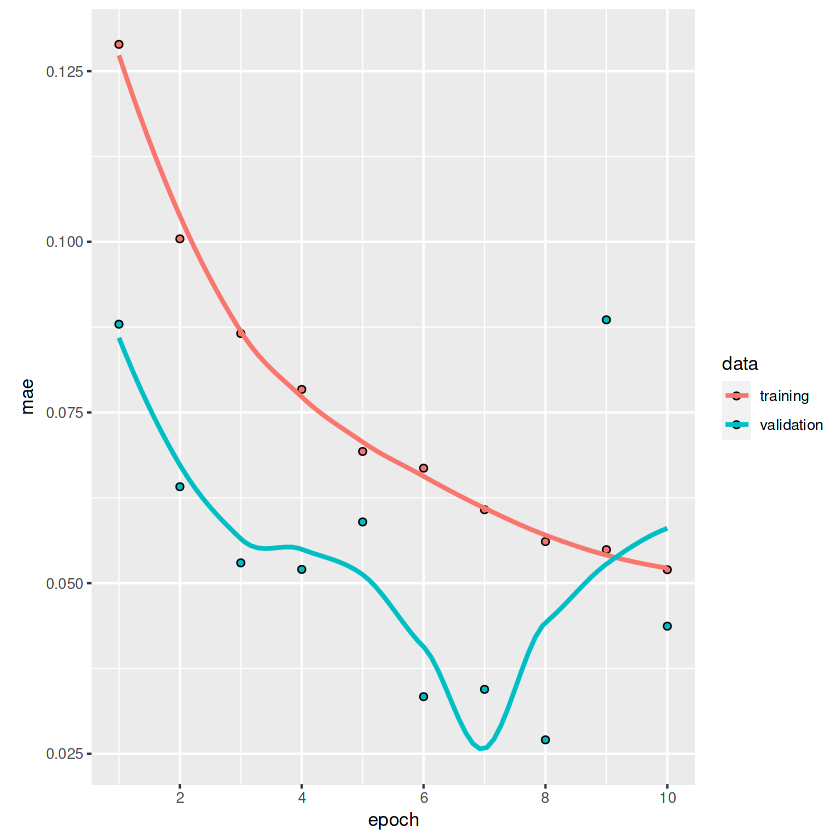

In [28]:
plot(history_dense, metrics = "mae")

Model wykazuje poprawę w dopasowaniu do danych treningowych, co widać po malejącym błędzie MAE w kolejnych epokach. Jednak po kilku epokach (około 3-4) błąd dla danych walidacyjnych zaczyna rosnąć, co sugeruje, że model zaczyna się przeuczać.

### Model oparty o konwolucje 1d
Model sieci konwolucyjnej 1D wykorzystuje warstwy konwolucyjne do przesuwania filtrów przez dane wejściowe, co pozwala na wyodrębnienie lokalnych cech i wzorców. Warstwy poolingowe (redukujące wymiarowość danych poprzez wybór najważniejszych cech z okna przesuwnego, takich jak maksymalna lub średnia wartość) są używane do redukcji wymiarowości danych, a warstwa globalnego uśredniania lub poolingowa na końcu umożliwiają agregację cech z całej sekwencji przed przekazaniem ich do warstwy gęstej, która generuje wyjście modelu. 

In [29]:
# Definicja modelu konwolucyjnego
inputs <- layer_input(shape = c(sequence_length, 1))
outputs <- inputs %>%
  layer_conv_1d(8, 30, activation = "relu") %>%
  layer_max_pooling_1d(2) %>%
  layer_conv_1d(8, 15, activation = "relu") %>%
  layer_max_pooling_1d(2) %>%
  layer_conv_1d(8, 7, activation = "relu") %>%
  layer_global_average_pooling_1d() %>%
  layer_dense(1)

model_conv <- keras_model(inputs, outputs)

# Kompilacja modelu
model_conv %>% compile(optimizer = "rmsprop",
                  loss = "mse",
                  metrics = list("mae"))

#historia modelu
history_conv <- model_conv %>%
  fit(train_dataset,
      epochs = 10,
      validation_data = val_dataset)

# Zapisanie modelu i historii
save_model_tf(model_conv, filepath = "models/conv.keras")
saveRDS(history_conv, "models/model_conv.rds")

In [30]:
# Ewaluacja modelu na zbiorze walidacyjnym
val_mae_conv <- unnormalize(evaluate(model_conv, val_dataset)[["mae"]])
sprintf("MAE na zbiorze walidacyjnym: %.2f", val_mae_conv)

# Ewaluacja modelu na zbiorze testowym
test_mae_conv <- unnormalize(evaluate(model_conv, test_dataset)["mae"])
sprintf("MAE na zbiorze testowym: %.2f", test_mae_conv)

[1] "MAE na zbiorze walidacyjnym: 306.71"

[1] "MAE na zbiorze testowym: 332.35"

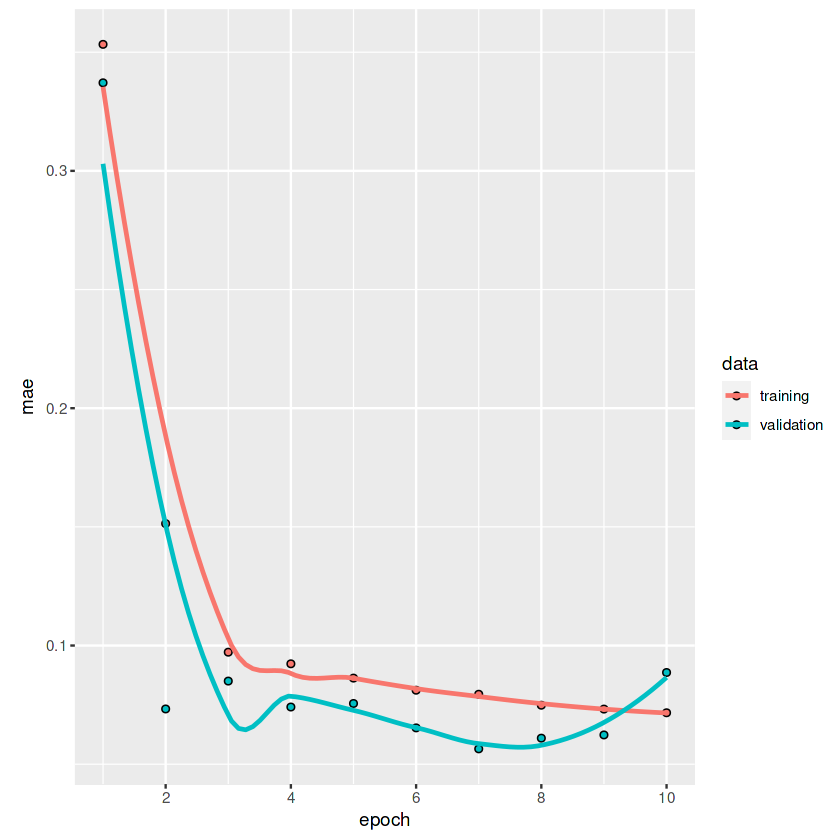

In [31]:
plot(history_conv, metrics = "mae")

Na wykresie dla modelu konwolucyjnego widać, że zarówno błąd dla danych treningowych, jak i walidacyjnych maleje w początkowych epokach, co wskazuje na poprawę dopasowania. Błąd walidacyjny początkowo rośnie, ale potem stabilizuje się i zmniejsza, co sugeruje lepsze dostosowanie modelu do danych. Można zauważyć mniejsze przeuczenie w porównaniu do modelu gęstego.

### Model LSTM
Modele LSTM są rodzajem rekurencyjnych sieci neuronowych (RNN), które charakteryzują się zdolnością do przechowywania długoterminowej pamięci, co pozwala na analizę zależności czasowych między danymi oraz regularyzację za pomocą technik takich jak recurrent dropout, co poprawia ich zdolność do generalizacji i zapobiega przeuczeniu.

In [32]:
# Definicja modelu
inputs <- layer_input(shape = c(sequence_length, 1))
outputs <- inputs %>%
  layer_lstm(32, recurrent_dropout = 0.25) %>%
  layer_dropout(0.5) %>%
  layer_dense(1)
model_lstm <- keras_model(inputs, outputs)

# Kompilacja modelu
model_lstm %>% compile(optimizer = "rmsprop",
                  loss = "mse",
                  metrics = "mae")

#historia modelu
history_lstm <- model_lstm %>%
  fit(train_dataset,
      epochs = 10,
      validation_data = val_dataset)

# Zapisanie modelu i historii
save_model_tf(model_lstm, "models/lstm.keras")
saveRDS(history_lstm, "models/lstm.rds")

In [33]:
# Ewaluacja modelu na zbiorze walidacyjnym
val_mae_lstm <- unnormalize(evaluate(model_lstm, val_dataset)[["mae"]])
sprintf("MAE na zbiorze walidacyjnym: %.2f", val_mae)

#testowym
test_mae_lstm <- unnormalize(evaluate(model_lstm, test_dataset)["mae"])
sprintf("Test MAE: %.2f", test_mae_lstm)

[1] "MAE na zbiorze walidacyjnym: 377.83"

[1] "Test MAE: 1206.27"

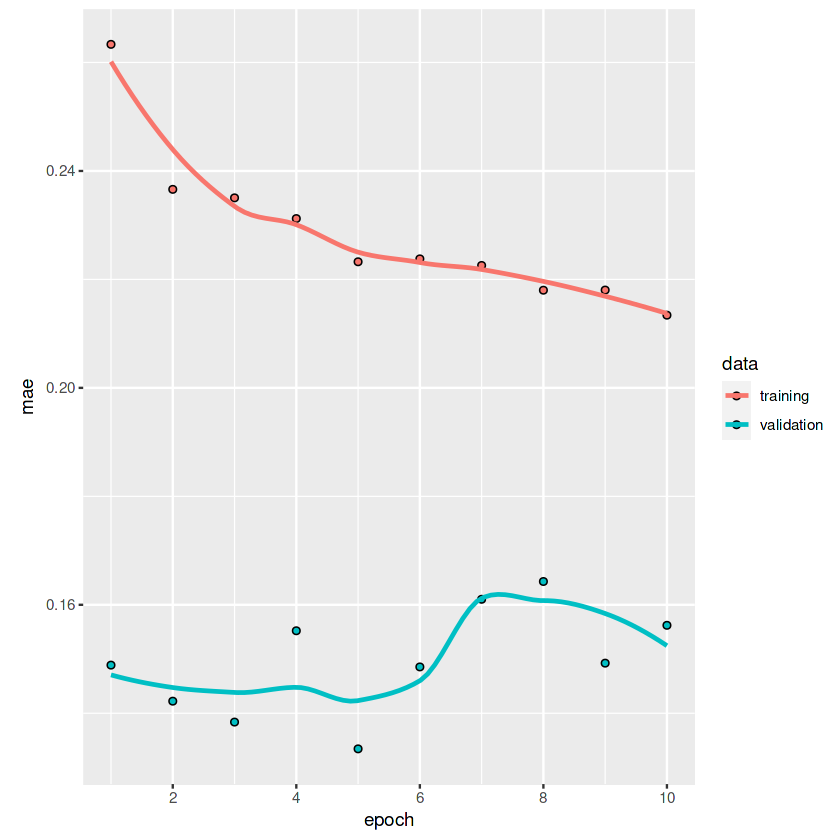

In [34]:
plot(history_lstm, metrics = "mae")

Na wykresie dla modelu LSTM widzimy, że błąd dla danych treningowych maleje, co oznacza poprawę dopasowania do danych. Początkowo błąd walidacyjny rośnie, osiąga maksimum około 5. epoki, a następnie zaczyna maleć. Sugeruje to, że model początkowo nieco się przeuczał, ale potem zaczął lepiej generalizować na danych walidacyjnych. 

### Model GRU
Model GRU  jest również typem rekurencyjnej sieci neuronowej (RNN), podobnym do LSTM. GRU jest mniej złożony niż LSTM, co sprawia, że jest łatwiejszy do szkolenia i szybszy w działaniu. Różni się od LSTM głównie przez brak dwóch bram (forget gate i input gate), zastępując je jedną bramą aktualizacji stanu. To uproszczenie sprawia, że model GRU jest często wybierany, gdy potrzebna jest skuteczna obsługa długoterminowych zależności w danych sekwencyjnych, ale przy niższej złożoności obliczeniowej i mniejszej ilości parametrów do trenowania.

In [35]:
#Definicja modelu
inputs <- layer_input(shape = c(sequence_length, 1))
outputs <- inputs %>%
  layer_gru(32, recurrent_dropout = 0.5, return_sequences = TRUE) %>%
  layer_gru(32, recurrent_dropout = 0.5) %>%
  layer_dropout(0.5) %>%
  layer_dense(1)
model_gru <- keras_model(inputs, outputs)

#Kompilacja modelu
model_gru %>% compile(optimizer = "rmsprop",
                  loss = "mse",
                  metrics = "mae")

#historia modelu
history_gru <- model_gru %>%
  fit(train_dataset,
      epochs = 10,
      validation_data = val_dataset)

# Zapisanie modelu i historii
save_model_tf(model_gru, filepath = "models/gru.keras")
saveRDS(history_gru, "models/gru.rds")

In [36]:
# Ewaluacja modelu na zbiorze walidacyjnym
val_mae_gru <- unnormalize(evaluate(model_gru, val_dataset)[["mae"]])
sprintf("MAE na zbiorze walidacyjnym: %.2f", val_mae)

# Ewaluacja modelu na zbiorze testowym
test_mae_gru <- unnormalize(evaluate(model_gru, test_dataset)["mae"])
sprintf("MAE na zbiorze testowym: %.2f", test_mae_gru)

[1] "MAE na zbiorze walidacyjnym: 377.83"

[1] "MAE na zbiorze testowym: 1253.46"

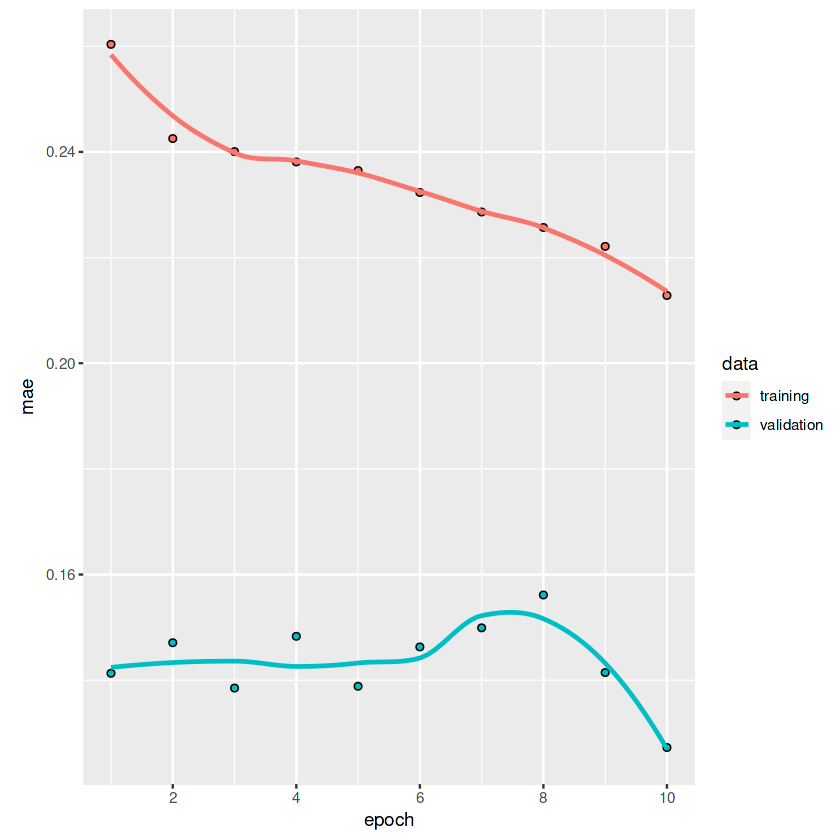

In [37]:
plot(history_gru, metrics = "mae")

Wartość MAE dla danych treningowych stopniowo maleje, co sugeruje, że model coraz lepiej dopasowuje się do danych treningowych. Z kolei wartość MAE dla danych walidacyjnych początkowo rośnie, a następnie zaczyna maleć. Może to wskazywać na początkowe przeuczenie się modelu, które zostaje później skorygowane.

### Dwukierunkowa sieć rekurencyjna
Dwukierunkowa sieć rekurencyjna jest rodzajem rekurencyjnej sieci neuronowej, która działa na sekwencjach danych w dwóch kierunkach: od początku do końca oraz od końca do początku. W przypadku modelu opartego na warstwie LSTM zastosowanie dwukierunkowości oznacza, że sieć analizuje informacje kontekstowe zarówno z przeszłości, jak i z przyszłości każdego punktu danych sekwencyjnych. Jest to przydatne, gdy istnieją zależności czasowe zarówno wstecz, jak i w przód, co pozwala na lepsze zrozumienie kontekstu danych i poprawę zdolności modelu do przewidywania na podstawie całej sekwencji.

In [ ]:
#Definicja modelu 
inputs <- layer_input(shape = c(sequence_length, 1))
outputs <- inputs %>%
  bidirectional(layer_lstm(units = 16)) %>%
  layer_dense(1)

model_bi <- keras_model(inputs, outputs)

#Kompilacja modelu
model_bi %>% compile(optimizer = "rmsprop",
                  loss = "mse",
                  metrics = "mae")

#historia modelu
history_bi <- model_bi %>%
  fit(train_dataset,
      epochs = 10,
      validation_data = val_dataset)

#zapisanie modelu i historii
save_model_tf(model_bi, "models/bi.keras")
saveRDS(history_bi, "models/bi.rds")

In [ ]:
# Ewaluacja modelu na zbiorze walidacyjnym
val_mae_bi <- unnormalize(evaluate(model_bi, val_dataset)[["mae"]])
sprintf("MAE na zbiorze walidacyjnym: %.2f", val_mae)

# Ewaluacja modelu na zbiorze testowym
test_mae_bi <- unnormalize(evaluate(model_bi, test_dataset)["mae"])
sprintf("MAE na zbiorze testowym: %.2f", test_mae_bi)

In [ ]:
plot(history_bi, metrics = "mae")

Wartość MAE dla danych treningowych gwałtownie maleje w pierwszych kilku epokach, co świadczy o szybkim uczeniu się modelu. Wartość MAE dla danych walidacyjnych również systematycznie maleje, co sugeruje, że model dobrze generalizuje na nowych danych. Brak wyraźnego wzrostu MAE dla danych walidacyjnych oznacza, że model nie przeucza się, a jego dopasowanie do danych walidacyjnych jest stabilne i poprawne.

## Porównanie modeli 

In [ ]:
# Utworzenie danych do tabeli
models <- c("Model bazowy", "Drzewo decyzyjne", "Drzewo decyzyjne (tuning)", 
            "SVM", "SVM (tuning)", "Sieć gęsta", "Sieć konwolucyjna 1D", 
            "LSTM", "GRU", "Sieć dwukierunkowa")
mae_validation <- c(val_mae, val_mae_tree, val_mae_tree_tuned, val_mae_svm, val_mae_svm_tuned, val_mae_dense, val_mae_conv, val_mae_lstm, val_mae_gru, val_mae_bi)
mae_test <- c(test_mae, test_mae_tree, test_mae_tree_tuned, test_mae_svm, test_mae_svm_tuned, test_mae_dense, test_mae_conv, test_mae_lstm, test_mae_gru, test_mae_bi)

# Tworzenie ramki danych
results <- data.frame(
  Model = models,
  MAE_Walidacyjny = mae_validation,
  MAE_Testowy = mae_test,
  stringsAsFactors = FALSE
)

# Wyświetlenie tabeli
print(results)

Na podstawie przedstawionych wyników można wyciągnąć następujące wnioski dotyczące skuteczności różnych modeli w kontekście błędów MAE na zestawach walidacyjnym i testowym:

1.Sieć gęsta osiągnęła najniższy błąd MAE na zbiorze testowym (343.2310) oraz na zbiorze walidacyjnym (299.5355). Oznacza to, że spośród wszystkich testowanych modeli, sieć gęsta najlepiej radzi sobie z przewidywaniem wyników zarówno na etapie walidacji, jak i testowania.

2.Model bazowy wykazuje znacznie wyższe wartości MAE zarówno na zestawie walidacyjnym (377.8298), jak i testowym (1273.5866) w porównaniu do większości innych modeli. Sugeruje to, że dalsze dostosowywanie modeli lub zmiana architektury przyniosły znaczną poprawę w jakości predykcji.

3.Tuning drzewa decyzyjnego przyniósł zauważalną poprawę w stosunku do podstawowego modelu drzewa decyzyjnego, zmniejszając błąd MAE zarówno na zbiorze walidacyjnym, jak i testowym. Jednak w porównaniu do najlepszych modeli, nadal pozostaje na średnim poziomie.

4.SVM z tuningiem wykazuje wysoki błąd MAE na zbiorze testowym (1490.9714), co może sugerować, że tuning nie przyniósł oczekiwanych rezultatów lub model nie jest optymalny dla tego zadania.

5.Widać znaczne różnice w skuteczności pomiędzy różnymi modelami, gdzie bardziej zaawansowane modele, takie jak sieć dwukierunkowa oraz sieci neuronowe, przeważają nad klasycznymi metodami, jak drzewo decyzyjne czy SVM.

6.Sieć dwukierunkowa jest jednym z modeli, który wykazuje dobrą stabilność między błędem walidacyjnym (294.0356) a testowym (599.6489), co może wskazywać na dobrze dopasowaną architekturę.

# Podsumowanie
Podsumowując, analiza różnych modeli uczenia maszynowego wykazała, że zaawansowane podejścia, takie jak sieci neuronowe, przewyższają klasyczne metody w kontekście przewidywania wyników na zestawach walidacyjnym i testowym. Sieć gęsta osiągnęła najlepsze wyniki, co sugeruje, że jest najbardziej efektywna w kontekście zadania, minimalizując błąd średniego błędu bezwzględnego (MAE). Model bazowy wykazywał znacznie wyższe wartości MAE, co wskazuje na konieczność stosowania bardziej złożonych modeli. Tuning hiperparametrów, zwłaszcza w przypadku drzewa decyzyjnego, przyniósł poprawę, choć nie osiągnął poziomu zaawansowanych sieci neuronowych. Problemy z modelem SVM, nawet po tuningu, wskazują, że nie jest on optymalny dla tego zadania. Różnice w skuteczności między modelami podkreślają znaczenie wyboru odpowiedniej architektury, a stabilność wyników sieci dwukierunkowej wskazuje na jej potencjał do efektywnego przewidywania w dłuższej perspektywie.